In [13]:
import re

def tokenize(text):
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    return words


text = ""
with open(r"..\book.txt", 'r', encoding="utf-8") as txt:
    text = txt.read()

In [14]:
tokens = tokenize(text)

In [15]:
import pymorphy3
from collections import defaultdict

morph = pymorphy3.MorphAnalyzer()

def lemmatize_and_filter(words):
    lemmas = []
    lemmas_pos = defaultdict(list)
    for word in words:
        parsed = morph.parse(word)[0]
        lemma = parsed.normal_form
        # if parsed.tag.POS not in {'PREP', 'NPRO', 'CONJ', 'PRCL', 'ADVB', 'NUMR', 'PRED', 'INTJ'}:
        lemmas.append(lemma)
        lemmas_pos[lemma].append(parsed.tag.POS)
    return lemmas, lemmas_pos
lemmas_marphy, lemmas_pos_m = lemmatize_and_filter(tokens)

In [16]:
from natasha import (
    Segmenter,
    MorphVocab,
    NewsEmbedding,
    NewsMorphTagger,
    NewsNERTagger,
    NamesExtractor,
    Doc
)
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
text2 = ""
with open(r"..\book.txt", 'r', encoding="utf-8") as txt:
    text2 = txt.read()
doc = Doc(text2)
doc.segment(segmenter)
doc.tag_morph(morph_tagger)
for token in doc.tokens:
     token.lemmatize(morph_vocab)

In [22]:
lemmas_natasha = []
lemmas_pos_n = defaultdict(list)
for token in doc.tokens:
    # if token.pos not in ['NUM', "ADV", "PRON", "PART", "SCONJ", "PUNCT", "ADP", "AUX", "DET", "CCONJ"]:
    if "-" not in list(token.lemma):
        lemmas_natasha.append(token.lemma)
    lemmas_pos_n[token.lemma].append(token.pos)

In [23]:
from collections import Counter
def pos_stats(poss):
    res = ''
    c_poss = Counter(poss)
    for i, freq in c_poss.items():
        res += f" {i} {round(freq/len(poss)*100, 2)}%;"
    return res
counter_m = Counter(lemmas_marphy)
top_20_m = Counter(counter_m).most_common()[:-20:-1]
print('-------------------pymorphy---------------')
for w, _ in top_20_m:
    print(f'{w} |{pos_stats(lemmas_pos_m[w])}')
counter_n = Counter(lemmas_natasha)
top_20_n = Counter(lemmas_natasha).most_common()[:-20:-1]
print('-------------------natasha---------------')
for w, _ in top_20_n:
    print(f'{w} |{pos_stats(lemmas_pos_n[w])}')

-------------------pymorphy---------------
немногий | ADJF 100.0%;
амнистия | NOUN 100.0%;
боженька | NOUN 100.0%;
шукать | INFN 100.0%;
соломный | ADJF 100.0%;
агроном | NOUN 100.0%;
остервениться | VERB 100.0%;
заложница | NOUN 100.0%;
выдалбливать | VERB 100.0%;
варево | NOUN 100.0%;
домовито | ADVB 100.0%;
орешник | NOUN 100.0%;
грибок | NOUN 100.0%;
повергать | VERB 100.0%;
оседлый | ADJS 100.0%;
пал | NOUN 100.0%;
гнездуть | VERB 100.0%;
пробудиться | GRND 100.0%;
серебрить | VERB 100.0%;
-------------------natasha---------------
глотошная | NOUN 100.0%;
свисавшие | NOUN 100.0%;
обламывал | X 100.0%;
обламывала | ADJ 100.0%;
амнистия | NOUN 100.0%;
боженька | VERB 100.0%;
топай | ADV 100.0%;
шукатя | NOUN 100.0%;
соломный | PROPN 100.0%;
кончили | NOUN 100.0%;
агроном | NOUN 100.0%;
остервениться | VERB 100.0%;
заложница | NOUN 100.0%;
поглядели | PROPN 100.0%;
обогревшись | NOUN 100.0%;
высушив | ADJ 100.0%;
казалось | ADV 100.0%;
выдалбливать | VERB 100.0%;
варево | VERB 100.0%

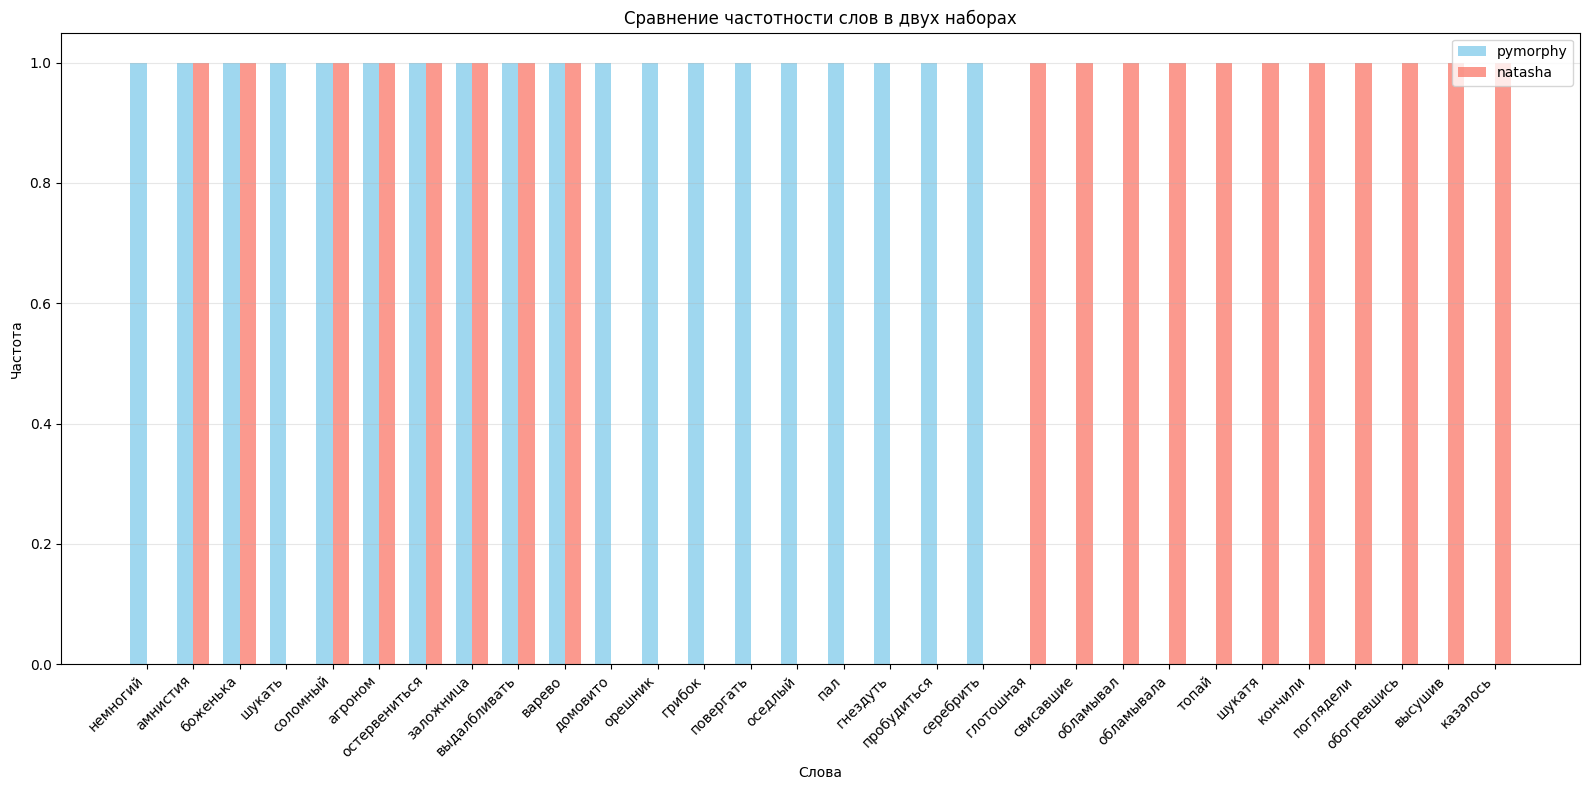

In [24]:
import matplotlib.pyplot as plt
from itertools import chain
import numpy as np
words1 = [item[0] for item in top_20_m]
freqs1 = [item[1] for item in top_20_m]
words2 = [item[0] for item in top_20_n]
freqs2 = [item[1] for item in top_20_n]

all_words = words1 + [word for word in words2 if word not in words1]
# Создаем частотные списки для объединенного набора слов
freqs1_full = [freqs1[words1.index(word)] if word in words1 else 0 for word in all_words]
freqs2_full = [freqs2[words2.index(word)] if word in words2 else 0 for word in all_words]

plt.figure(figsize=(16, 8))

# Настройки для столбцов
bar_width = 0.35
x_pos = np.arange(len(all_words))

# Создаем две гистограммы
plt.bar(x_pos - bar_width/2, freqs1_full, bar_width, 
        color='skyblue', label='pymorphy', alpha=0.8)
plt.bar(x_pos + bar_width/2, freqs2_full, bar_width, 
        color='salmon', label='natasha', alpha=0.8)

# Настройки графика
plt.xticks(x_pos, all_words, rotation=45, ha='right')
plt.title('Сравнение частотности слов в двух наборах')
plt.xlabel('Слова')
plt.ylabel('Частота')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Отчет

## Сравнение анализаторов

Natasha уже использует pymorthy внутри себя. То-есть определение части речи идет через нейросеть, а нормализация через алгоритм pymorthy. Поэтому основные различия связаны с неправильным определением части речи. Например, в тексте есть глагол `шукать`, но SlovNet определил его в существительным, из-за чего нормальная форма стала `шукатя`. Как и глагол `обламывала` в SlovNet стал прилагательным, и из-за этого нормальная форма стала неверной. Как итог, в целом такие случаи редки, однако можно отметить, что нейросетевой метод может ошибаться и определять части речи не правильно на, видимо, незнакомых словах, из-за чего как следствие страдает ламмантизация.

